# Qiskit 102: Building a Qiskit pattern workflow

## Step 1: Map classical problem to quantum circuits and observables

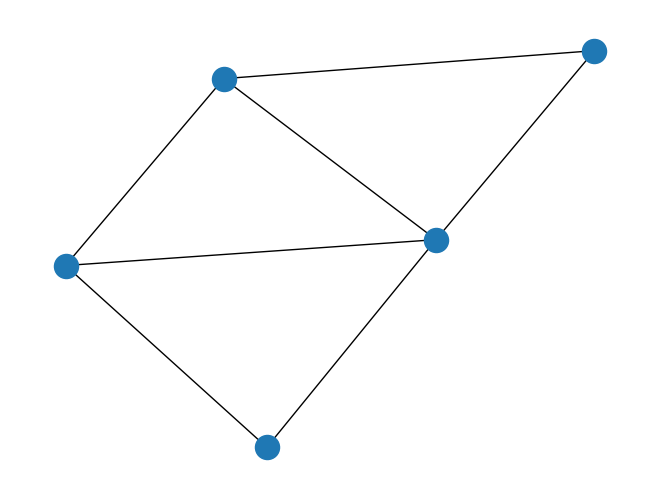

In [3]:
import rustworkx as rx
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter
from qiskit.circuit.library import RZZGate, RXGate


def max_cut_hamiltonian(graph: rx.PyGraph) -> SparsePauliOp:
    terms = [["", [], 0.5 * graph.num_edges()]]
    for edge in graph.edge_list():
        terms.append(["ZZ", edge, -0.5])
    return SparsePauliOp.from_sparse_list(terms, num_qubits=graph.num_nodes())


def qaoa_circuit(graph: rx.PyGraph, p: int) -> QuantumCircuit:
    betas = [Parameter(f"b_{i}") for i in range(p)]
    gammas = [Parameter(f"g_{i}") for i in range(p)]
    qubits = QuantumRegister(graph.num_nodes())
    circuit = QuantumCircuit(qubits)
    circuit.h(qubits)
    for beta, gamma in zip(betas, gammas):
        for (i, j) in graph.edge_list():
            circuit.append(RZZGate(gamma), [qubits[i], qubits[j]])
        for q in qubits:
            circuit.append(RXGate(beta), [q])
    return circuit


n_qubits = 5
probability = 0.8
p = 1
graph = rx.undirected_gnp_random_graph(num_nodes=n_qubits, probability=probability)
observable = max_cut_hamiltonian(graph)
circuit = qaoa_circuit(graph, p=p)
observable

from rustworkx.visualization import mpl_draw

mpl_draw(graph)

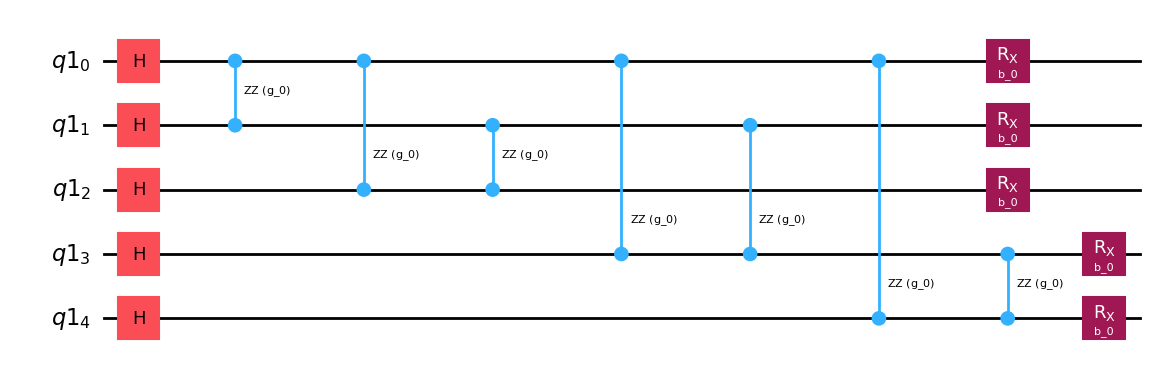

In [4]:
circuit.draw("mpl")

## Step 2: Optimize problem for execution on quantum hardware

In [5]:
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

backend = FakeAlmadenV2()

In [23]:
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

backend = FakeAlmadenV2()


pass_manager = generate_preset_pass_manager(
    optimization_level=3,
    backend=backend,
    # initial_layout=[0, 1, 2, 3, 4],
)

isa_circuit = pass_manager.run(circuit)
isa_observable = observable.apply_layout(isa_circuit.layout)

In [25]:
observable

SparsePauliOp(['IIIII', 'IIIZZ', 'IIZIZ', 'IIZZI', 'IZIIZ', 'IZIZI', 'ZIIIZ', 'ZZIII'],
              coeffs=[ 3.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j,
 -0.5+0.j])

In [8]:
isa_observable

SparsePauliOp(['IIIIIIIIIIIIIIIIIIII', 'IZIIIZIIIIIIIIIIIIII', 'IZIIIIIIIIZIIIIIIIII', 'IIIIIZIIIIZIIIIIIIII', 'IZIIIIZIIIIIIIIIIIII', 'IIIIIZZIIIIIIIIIIIII', 'IZIIIIIZIIIIIIIIIIII', 'IIIIIIZZIIIIIIIIIIII'],
              coeffs=[ 3.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j,
 -0.5+0.j])

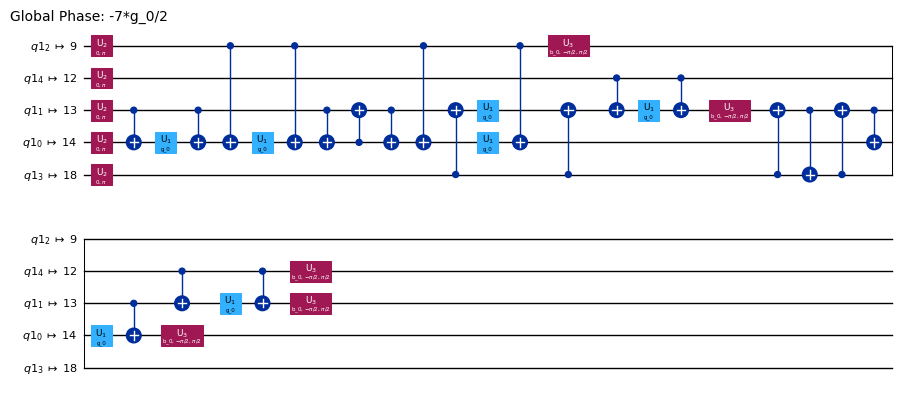

In [9]:
isa_circuit.draw("mpl", idle_wires=False, scale=0.5)

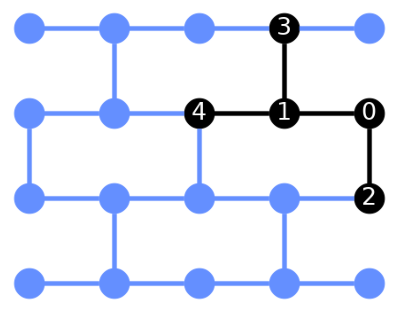

In [24]:
from qiskit.visualization import plot_circuit_layout

plot_circuit_layout(isa_circuit, backend)

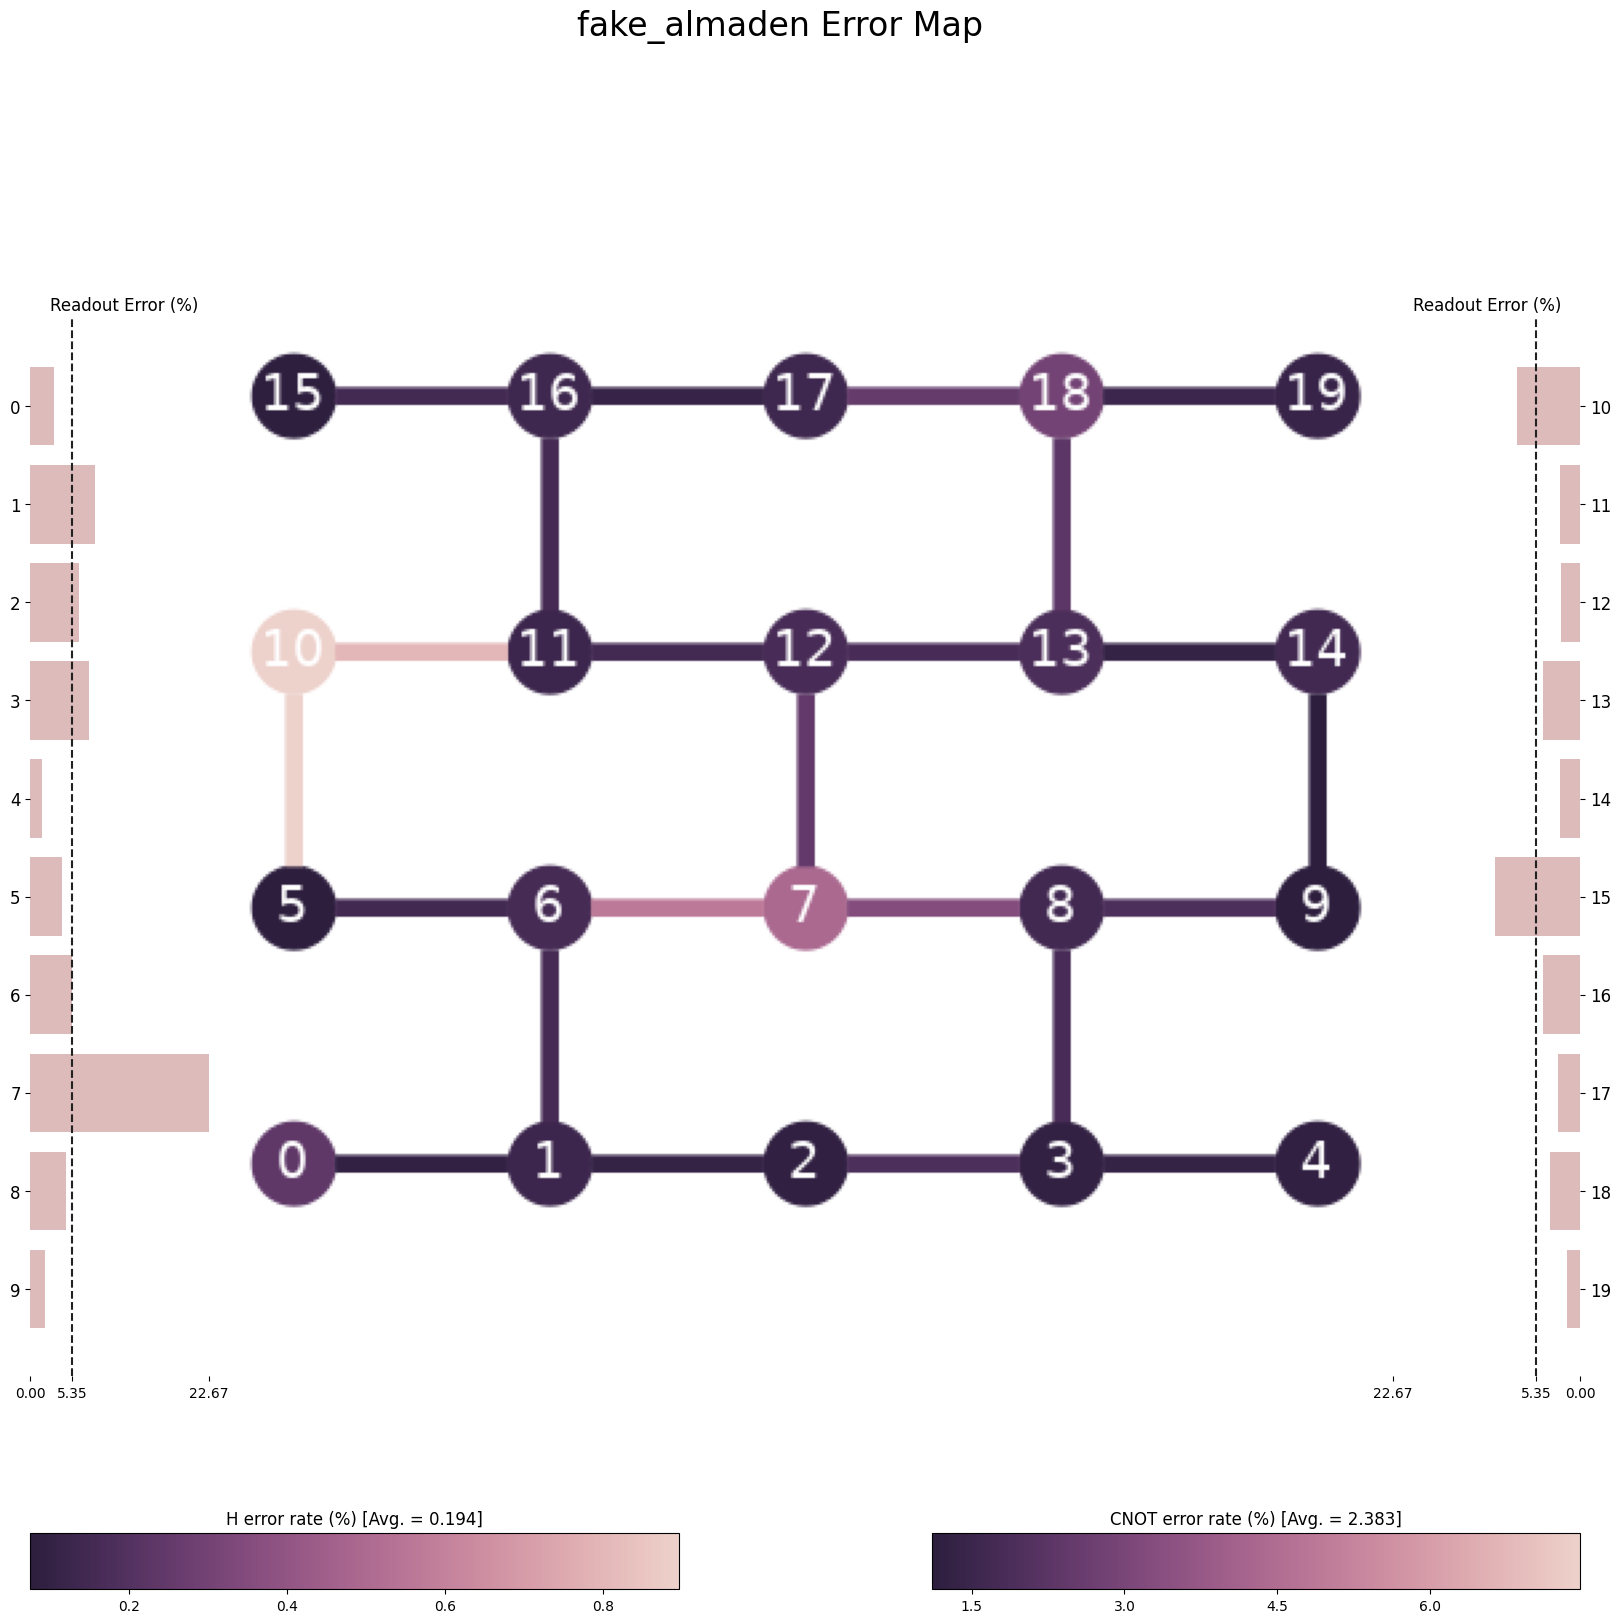

In [11]:
from qiskit.visualization import plot_error_map

plot_error_map(backend, figsize=(20, 20))

## Step 3: Execute circuits using Qiskit Primitives

In [12]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator
import numpy as np

rng = np.random.default_rng()
params = rng.uniform(-np.pi, np.pi, size=circuit.num_parameters)


estimator = Estimator(mode=backend)

pub = (isa_circuit, isa_observable, params)
job = estimator.run([pub])

In [13]:
result = job.result()
pub_result = result[0]
expectation_val = float(pub_result.data.evs)
expectation_val

3.646728515625

In [14]:
from qiskit_ibm_runtime import Session
import scipy.optimize


def f(x: np.ndarray, estimator: Estimator) -> float:
    pub = (isa_circuit, isa_observable, x)
    job = estimator.run([pub])
    result = job.result()
    pub_result = result[0]
    val = -float(pub_result.data.evs)
    print(f"Objective function value: {val}")
    return val


session = Session(backend)
estimator = Estimator(mode = session)
result = scipy.optimize.minimize(
    f, params, args=(estimator,), method="COBYLA", options=dict(maxiter=5)
)

Objective function value: -3.62646484375
Objective function value: -3.462890625
Objective function value: -3.672119140625
Objective function value: -3.527099609375


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


KeyboardInterrupt: 